# Graph resonators

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import string
import replicator_dynamics as rd
import pandas as pd
import seaborn as sns
import itertools
# import resonator_circuit as rc
import graph_tools as gt
%load_ext autoreload
%autoreload 2

In [2]:
alphabet = string.ascii_lowercase

### Generate motifs

In [3]:
motifs = gt.group_motifs(motif_size=4)

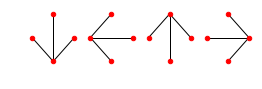

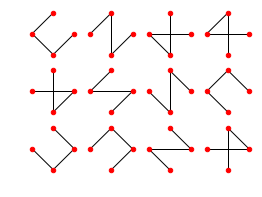

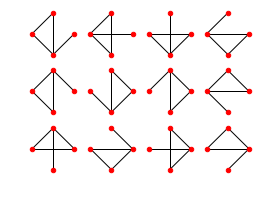

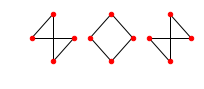

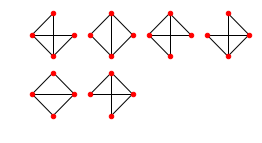

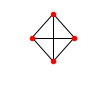

In [4]:
gt.plot_motifs(motifs)

### Choose pair of isomorphic graphs

In [5]:
aj1 = motifs[0][0]
aj2 = motifs[0][1]

In [6]:
G1 = nx.from_numpy_matrix(aj1)
G1 = nx.relabel_nodes(G1, {x:alphabet[x] for x in np.arange(len(G1))})
G2 = nx.from_numpy_matrix(aj2)
G2 = nx.relabel_nodes(G2, {x:alphabet[-x-1] for x in np.arange(len(G2))})

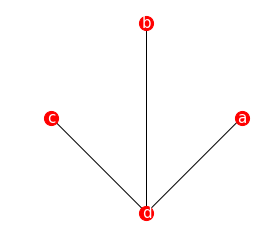

In [7]:
gt.draw_graph(G1)

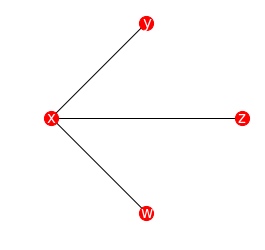

In [8]:
gt.draw_graph(G2)

## Isomorphism via replicator dynamics (Pelillo, 1999)

### Generate association graph

In [9]:
AG, am, labels = gt.association_graph(G1, G2)

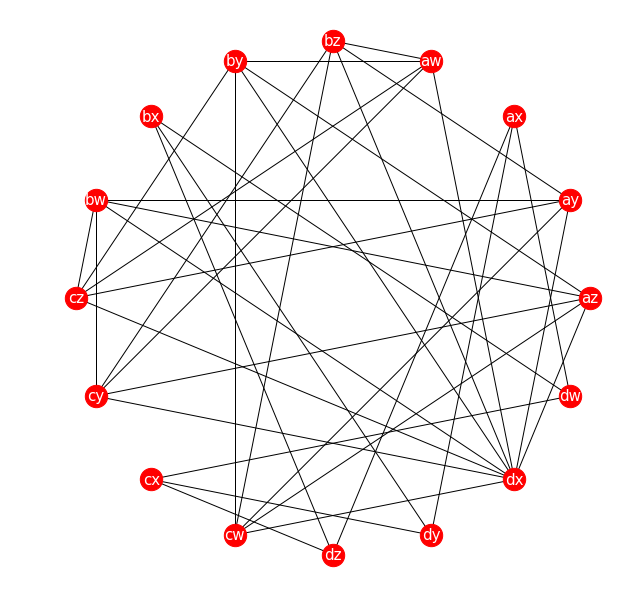

In [10]:
gt.draw_graph(AG, size=8, node_size=500)

In [452]:
xs, x = rd.run_dynamics(am)

converged in 42 iterations


/Users/Sophia/py3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


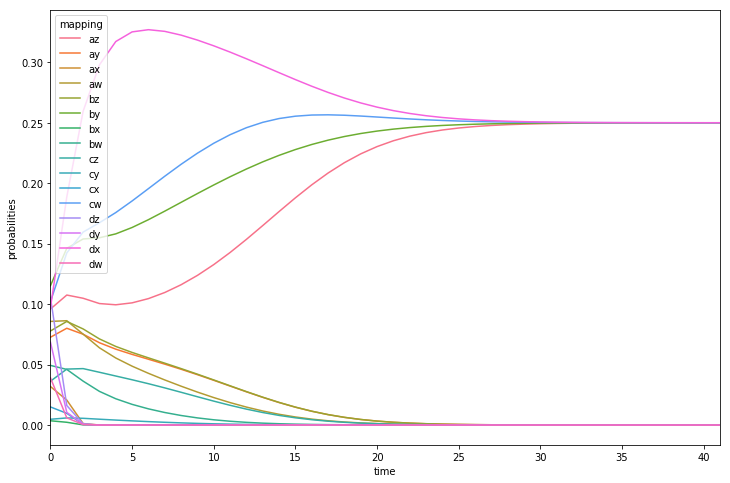

In [455]:
rd.plot_resonator_dynamics(xs, AG)

In [456]:
max_clique = [list(AG.nodes())[i] for i in range(len(x)) if x[i] >= 1/len(G1) - .1/len(G1)]

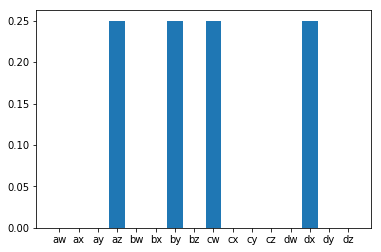

In [460]:
plt.bar(AG.nodes(), x);

In [458]:
MC = AG.subgraph(max_clique)

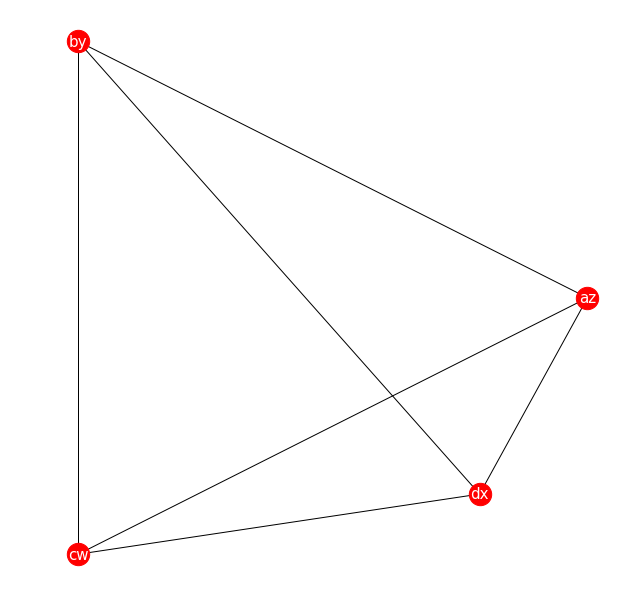

In [459]:
plt.figure(figsize=(8,8))
pos = nx.drawing.layout.circular_layout(AG)
nx.draw(MC, pos, node_size=500, with_labels=True, font_size=15, font_color='white')

### Success!

## Graph isomorphism with VSA (Gayler & Levy)

In [122]:
def normalize(x):
    return x / np.sum(x)

In [143]:
def permdict(a, size):
    dims = a.shape[1]
    w = np.zeros((size, dims))
    p1 = []
    p2 = []
    for k in range(size):
        p1.append(get_permutation(dims))
        p2.append(get_permutation(dims))
        for j in range(a.shape[0]):
            x = a[j]
            w[k] = w[k] + x * x[p1[k]] * x[p2[k]]
    d = {'w': w, 'p1': p1, 'p2': p2}
    return d

In [118]:
def cleandict(a):
    return a

In [461]:
def init(n, N, association_matrix, dim=20000, pdsize=50):
    V1 = ((np.random.randn(n, dim) < 0) * 2) - 1
    V2 = ((np.random.randn(n, dim) < 0) * 2) - 1
    e = np.zeros((N, dim))
    c = {}
    for i in range(N):
        k, j = np.unravel_index(i, (n, n))
        e[i] = V1[j] * V2[k]
    c['pd'] = permdict(e, pdsize)
    c['cd'] = cleandict(e)
    x = np.sum(e, axis=0)
    x = normalize(x)
    W = np.zeros(dim)
    for ih, row in enumerate(association_matrix):
        for jk, col in enumerate(row):
            h, i = np.unravel_index(ih, (n,n))
            k, j = np.unravel_index(jk, (n,n))
            if association_matrix[ih, jk] == 1:
#             if i != j and h != k:
                W += V1[i] * V1[j] * V2[h] * V2[k]
    return V1, V2, W, x, c

In [243]:
def probs(x, c):
    c = c['cd']
    N = c.shape[0]
    v = np.zeros(N)
    for k in range(N):
        v[k] = np.dot(x, c[k]) / len(x)
    v = normalize(v).T
    return v

In [188]:
def simil(x, y):
    return np.dot(x, y) / len(x)

In [186]:
def propogate(W, x):
    return W * x

In [190]:
def cleanup(x, c):
    if c.shape[0] != c.shape[1]:
        y = np.zeros(len(x))
        for k in range(c.shape[0]):
            ck = c[k]
            s = simil(x, ck)
            y += s * ck
    else:
        y = (x * c) / len(x)
    return y

In [313]:
def intersect(x, y, c):
    pd = c['pd']
    w = pd['w']
    p1 = pd['p1']
    p2 = pd['p2']
    z = np.zeros(len(x))
    for k in range(w.shape[0]):
        z += x[p1[k]] * y[p2[k]] * w[k]
    z /= w.shape[0]
    z = cleanup(z, c['cd'])
    return z

In [323]:
def squash(x):
    return x / np.max(abs(x))

converged in 45 iterations
max clique: ['az', 'by', 'cw', 'dx']


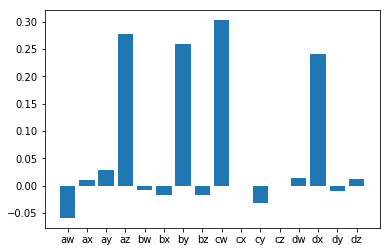

In [468]:
epsilon = 1e-4
zero = 0.1
n = len(aj1)
N = n**2
dim = 20000
V1, V2, W, x, c = init(n, N, am)
h = []
xprev = x
i = 0
d = 1
while d > epsilon:
    h.append(probs(x, c))
    p = propogate(W, x)
    x = intersect(xprev, p, c)
    x = squash(x)
    d = np.sqrt(np.sum((x - xprev)**2))
    xprev = x
    i += 1
print('converged in {} iterations'.format(i))
probabilities = probs(x,c)
win = np.where(probabilities > zero)[0]
mc = [list(AG.nodes())[x] for x in win]
print('max clique: {}'.format(mc))
plt.bar(AG.nodes(), probabilities);

/Users/Sophia/py3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


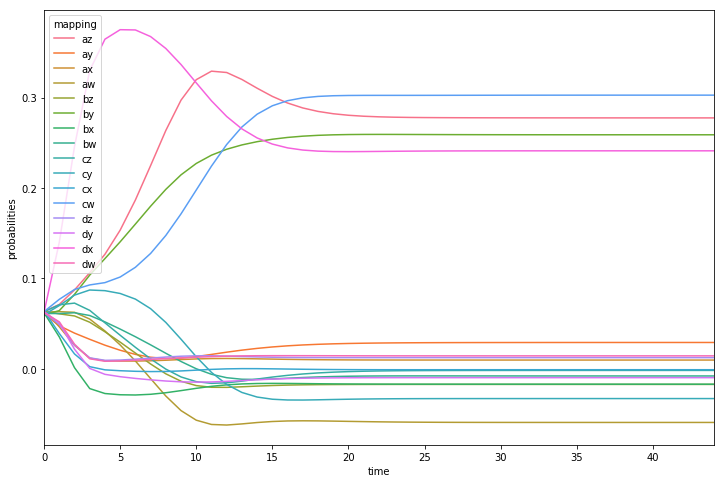

In [469]:
rd.plot_resonator_dynamics(h, AG)

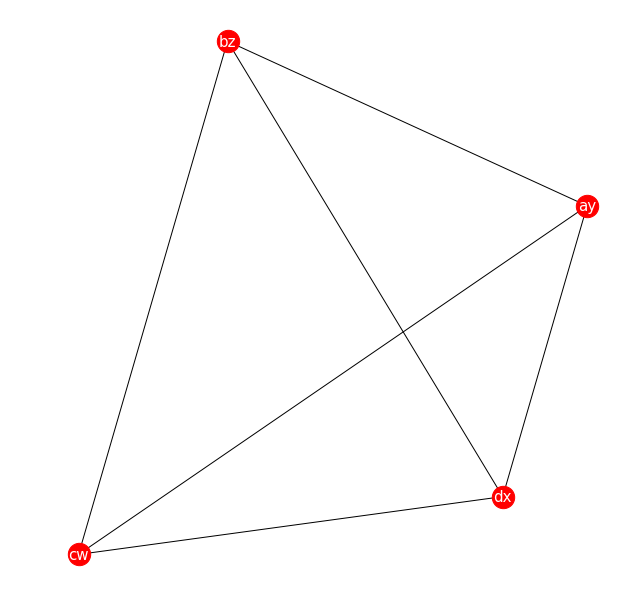

In [464]:
MC = AG.subgraph(mc)
plt.figure(figsize=(8,8))
pos = nx.drawing.layout.circular_layout(AG)
nx.draw(MC, pos, node_size=500, with_labels=True, font_size=15, font_color='white')

### Success!

In [17]:
def vector_representation(graph, n=100):
    nodes = ((np.random.randn(len(graph), n) < 0) * 2) - 1
    edges = np.zeros((n)
    for e in graph.edges():
        edges += nodes[e[0]] * nodes[e[1]]
    return nodes, edges

In [32]:
def resonate(G1, G2, n=100):
    G1_nodes, G1_edges = vector_representation(G1, n)
    G2_nodes, G2_edges = vector_representation(G2, n)
    x = np.sum(G1_nodes, axis=0) * np.sum(G2_nodes, axis=0)
    w = G1_edges * G2_edges
    pi = x * w
    p1 = get_permutation(n)
    p2 = get_permutation(n)
    register_1 = permute(x, p1)
    register_2 = permute(pi, p2)
    register_3 = register_1 * register_2
    register_4 = np.sum(x * permute(x, p1) * permute(x, p2) + pi * permute(pi, p1) * permute(pi, p2), axis=0)
    register_5 = register_3 * register_4 
    

    

In [110]:
G1_nodes, G1_edges = vector_representation(G1, n)
G2_nodes, G2_edges = vector_representation(G2, n)
x = np.sum(G1_nodes, axis=0) * np.sum(G2_nodes, axis=0)
w = G1_edges * G2_edges
pi = x * w
p1 = get_permutation(n)
p2 = get_permutation(n)
register_1 = permute(x, p1)
register_2 = permute(pi, p2)
register_3 = register_1 * register_2
register_4 = x * permute(x, p1) * permute(x, p2) + pi * permute(pi, p1) * permute(pi, p2)
register_5 = register_3 * register_4 
    

In [66]:
def get_permutation(size):
    return np.random.choice(size, size, replace=False)

In [101]:
def permute(vector, permutation):
#     for i, v in enumerate(vector_set):
    vector = np.array([x for i, x in sorted(zip(permutation, vector))])
    return vector

In [60]:
permutation, vector = permute(x)